<a href="https://colab.research.google.com/github/Tahagho82/Pneumonia-Detection-from-Chest-X-rays-with-CNNs-And-Grad-CAM/blob/main/Pneumonia_Detection_from_Chest_X_rays_with_CNNs_%26_Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [2]:
import os

DIR = os.path.join(path,'chest_xray')
DIR, os.listdir(DIR)

('/kaggle/input/chest-xray-pneumonia/chest_xray',
 ['chest_xray', '__MACOSX', 'val', 'test', 'train'])

In [3]:
os.listdir(os.path.join(DIR,'train'))

['PNEUMONIA', 'NORMAL']

In [4]:
BATCH_SIZE = 32
LR = 1e-2
EPOCHS = 15
IMG_SIZE= (224,224)
SEED = 42
OUTPUT_DIR = f"/outputs/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers

print("Train dataset  : ")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DIR,'train'),
    labels='inferred',
    label_mode='binary',
    image_size= IMG_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed= SEED,
)

print('Test datset  : ')
test_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DIR,'test'),
    labels = 'inferred',
    label_mode = 'binary',
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = False,
    seed = SEED
)

print('Validation dataset  : ')
val_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DIR,'val'),
    labels = 'inferred',
    label_mode = 'binary',
    image_size = IMG_SIZE,
    batch_size =BATCH_SIZE,
    shuffle = False,
    seed = SEED
)
data_augmentation = models.Sequential([
    layers.RandomRotation(0.05),
    layers.RandomTranslation(0.05, 0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])


train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))

Train dataset  : 
Found 5216 files belonging to 2 classes.
Test datset  : 
Found 624 files belonging to 2 classes.
Validation dataset  : 
Found 16 files belonging to 2 classes.


In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [8]:
for imgs , labels in train_dataset.take(1):
  print('One batch imgs shape : ',imgs.shape)
  print('One batch labels shape : ',labels.shape)
  print('Sample labels : ',labels[:10].numpy())



One batch imgs shape :  (32, 224, 224, 3)
One batch labels shape :  (32, 1)
Sample labels :  [[1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


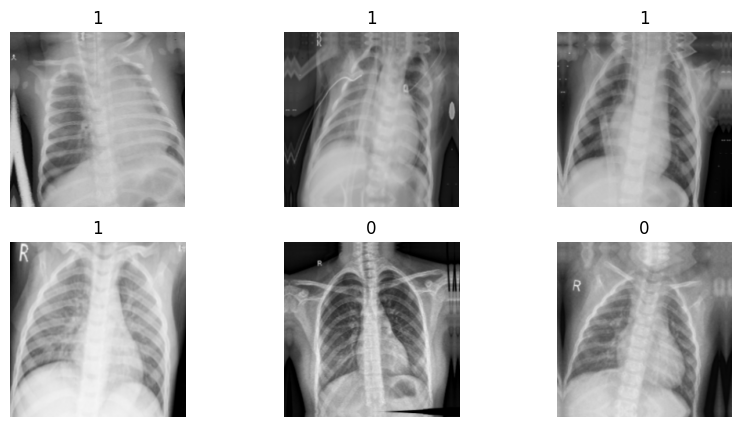

In [9]:
import matplotlib.pyplot as plt

for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 5))
    for i in range(6):
        ax = plt.subplot(2, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
    plt.show()


In [10]:
from tensorflow.keras import layers, applications, optimizers, callbacks, models,metrics

'''
Since we used a transfer learning model, all of its layers are treated as a single block.
Therefore, we need to adjust how the model is integrated so that the layers are exposed individually, allowing us to apply Grad-CAM properly.
'''
# base = applications.ResNet50(include_top=False, weights='imagenet',input_shape = IMG_SIZE+(3,))
# base.trainable= False

input = layers.Input(shape = IMG_SIZE+ (3,))

base = applications.ResNet50(weights="imagenet", include_top=False, input_tensor=input)
base.trainable = True
for base_layer in base.layers[:-10]:
  base_layer.trainable = False

x = base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(1,activation = 'sigmoid')(x)
model = models.Model(input,output)


model.compile(optimizer= optimizers.Adam(LR),
              loss = 'binary_crossentropy',
              metrics=[
                  metrics.BinaryAccuracy(name="acc"),
                  metrics.AUC(curve="ROC", name="auc"),
                  metrics.AUC(curve="PR", name="aupr")]
              )
cb = [
  callbacks.ModelCheckpoint(f"{OUTPUT_DIR}/best.h5", monitor="val_auc", mode="max",
                            save_best_only=True, verbose=1),
  callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=5, restore_best_weights=True),
  callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1),
  callbacks.CSVLogger(f"{OUTPUT_DIR}/train_log.csv"),
  callbacks.TensorBoard(log_dir=f"{OUTPUT_DIR}/tb", histogram_freq=0)
]

hist = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, callbacks=cb)



Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - acc: 0.9103 - auc: 0.9432 - aupr: 0.9718 - loss: 0.2868
Epoch 1: val_auc improved from -inf to 0.87500, saving model to /outputs//best.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 149ms/step - acc: 0.9105 - auc: 0.9434 - aupr: 0.9718 - loss: 0.2864 - val_acc: 0.8125 - val_auc: 0.8750 - val_aupr: 0.9177 - val_loss: 1.7572 - learning_rate: 0.0100
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - acc: 0.9709 - auc: 0.9916 - aupr: 0.9959 - loss: 0.0938
Epoch 2: val_auc improved from 0.87500 to 0.93750, saving model to /outputs//best.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - acc: 0.9709 - auc: 0.9916 - aupr: 0.9959 - loss: 0.0938 - val_acc: 0.6875 - val_auc: 0.9375 - val_aupr: 0.8889 - val_loss: 0.9898 - learning_rate: 0.0100
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - acc: 0.9777 - auc: 0.9957 - aupr: 0.9982 - loss: 0.0685
Epoch 3: val_auc improved from 0.93750 to 1.00000, saving model to /outputs//best.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 97ms/step - acc: 0.9777 - auc: 0.9957 - aupr: 0.9982 - loss: 0.0685 - val_acc: 0.9375 - val_auc: 1.0000 - val_aupr: 1.0000 - val_loss: 0.0706 - learning_rate: 0.0100
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - acc: 0.9749 - auc: 0.9950 - aupr: 0.9976 - loss: 0.0726
Epoch 4: val_auc did not improve from 1.00000
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - acc: 0.9749 - auc: 0.9950 - aupr: 0.9976 - loss: 0.0725 - val_acc: 0.6250 - val_auc: 0.8125 - val_aupr: 0.7273 - val_loss: 3.1470 - learning_rate: 0.0100
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - acc: 0.9863 - auc: 0.9977 - aupr: 0.9991 - loss: 0.0418
Epoch 5: val_auc did not improve from 1.00000

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - acc: 0.9863 - auc: 0.9977 - aupr: 0.9991 - loss: 0.0418 - val_acc: 0.8125 - val_auc: 0.8750 - val_aupr: 0.8000 - val_loss: 1.7589 - learning_rate: 0.0100
Epoch 6/15
16

In [11]:
# %load_ext tensorboard
# %tensorboard --logdir {OUTPUT_DIR}/tb

In [12]:
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report
import numpy as np

y_true = []
y_prob = []

for x,y in test_dataset:
  p = model.predict(x,verbose=0)
  y_prob.extend(p.ravel().tolist())
  y_true.extend(y.numpy().ravel().tolist())


y_true = np.array(y_true)
y_pred = np.array(y_prob)
y_pred = (y_pred>=0.5).astype(int)

print("Accuracy:", (y_pred == y_true).mean())
print("ROC-AUC:", roc_auc_score(y_true, y_prob))
print("PR-AUC :", average_precision_score(y_true, y_prob))
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, digits=4))



Accuracy: 0.9182692307692307
ROC-AUC: 0.9610070129300899
PR-AUC : 0.9656622133006726
[[204  30]
 [ 21 369]]
              precision    recall  f1-score   support

         0.0     0.9067    0.8718    0.8889       234
         1.0     0.9248    0.9462    0.9354       390

    accuracy                         0.9183       624
   macro avg     0.9157    0.9090    0.9121       624
weighted avg     0.9180    0.9183    0.9179       624



In [13]:
# ResNet50 layers
for layer in base.layers:
    print(layer.name)


input_layer_1
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn


/tmp/ipython-input-2775942476.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"Original (Label={int(sample_label)})")


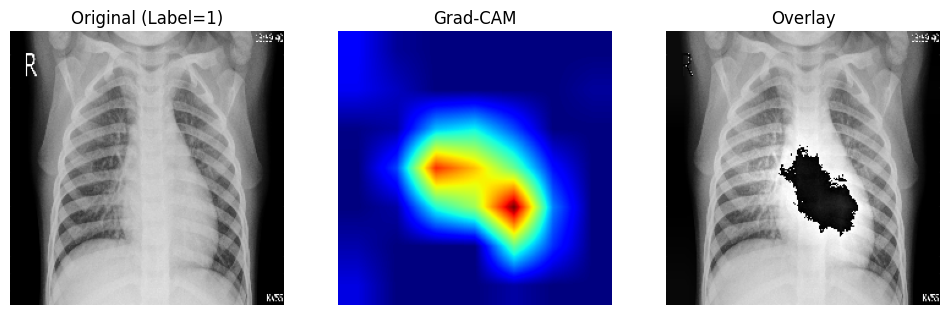

In [17]:
import numpy as np
import random

# Last Conv layer in ResNet50
last_conv_layer_name = "conv5_block3_out"


def make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv5_block3_out"):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[last_conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-10)
    return heatmap.numpy()

# Random img from train dataset
all_images, all_labels = [], []
for images, labels in test_dataset:
    all_images.extend(images.numpy())
    all_labels.extend(labels.numpy())

idx = random.randint(0, len(all_images)-1)
sample_img = all_images[idx].astype("uint8")
sample_label = all_labels[idx]
img_array = tf.expand_dims(sample_img, axis=0)

# generate Heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
heatmap = tf.image.resize(np.expand_dims(heatmap, axis=-1), IMG_SIZE).numpy()
heatmap = np.squeeze(heatmap)


plt.figure(figsize=(12,4))

plt.subplot(1, 3, 1)
plt.imshow(sample_img)
plt.axis("off")
plt.title(f"Original (Label={int(sample_label)})")

plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap="jet")
plt.axis("off")
plt.title("Grad-CAM")

superimposed = np.uint8(255 * (0.4 * heatmap[..., None] + sample_img / 255.0))
plt.subplot(1, 3, 3)
plt.imshow(superimposed)
plt.axis("off")
plt.title("Overlay")

plt.show()
